# Swipe_Identifier - Random Forest Modeli

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier # Random Forest kütüphanesi

# Görselleştirme ayarları (isteğe bağlı ama güzel görünür)
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Kütüphaneler başarıyla yüklendi.")

Kütüphaneler başarıyla yüklendi.


## 1. Veri Yükleme ve İlk İnceleme

In [10]:
# ESP32 Arduino kodundaki başlık sırasına göre doğru sütun isimlerini tanımlayalım
column_names = [
    "user_trial", "timestamp",
    "rawT9", "rawT8", "rawT7", "rawT0", "rawT2", "rawT3", "rawT6", "rawT5", "rawT4",
    "durationT9", "durationT8", "durationT7", "durationT0", "durationT2", "durationT3", "durationT6", "durationT5", "durationT4"
]

try:
    # CSV'yi oku, ilk satırı (ESP32 başlığı) atla ve kendi sütun isimlerimizi ver.
    df = pd.read_csv("veriseti4kisi.csv", header=None, skiprows=1, names=column_names)
    print("Veriseti başarıyla yüklendi ve sütun isimleri atandı.")
except FileNotFoundError:
    print("HATA: 'veriseti.csv' dosyası bulunamadı. Lütfen dosyanın doğru klasörde olduğundan emin olun.")
    df = None
except Exception as e:
    print(f"Veri yüklenirken bir hata oluştu: {e}")
    df = None

if df is not None:
    print("\nVeri setinin ilk 5 satırı:")
    print(df.head())
    print("\nVeri seti bilgileri:")
    df.info()
    print("\nVeri setinin boyutu (satır, sütun):")
    print(df.shape)
else:
    print("\nVeri yüklenemediği için işlem devam edemiyor.")

Veriseti başarıyla yüklendi ve sütun isimleri atandı.

Veri setinin ilk 5 satırı:
  user_trial  timestamp  rawT9  rawT8  rawT7  rawT0  rawT2  rawT3  rawT6  \
0    User0.0      32626     13     79     73     64     65     66     73   
1    User0.0      32726     20     76     73     64     63     64     72   
2    User0.0      32826     84     13     71     63     61     63     70   
3    User0.0      32926     86     14     72     63     61     65     73   
4    User0.0      33026     83     78     17     63     61     63     71   

   rawT5  rawT4  durationT9  durationT8  durationT7  durationT0  durationT2  \
0     71     73         113           0           0           0           0   
1     69     73         213           0           0           0           0   
2     69     72           0          43           0           0           0   
3     73     76           0         143           0           0           0   
4     72     76           0           0          23           0   

## 2. Veri Ön İşleme

In [11]:
if df is not None:
    try:
        # 'user_trial' sütunundan sadece kullanıcı ID'sini (örn: "User0") ayıklayalım
        df['UserID'] = df['user_trial'].apply(lambda x: str(x).split('.')[0])
        print("'UserID' sütunu başarıyla oluşturuldu.")

        print("\nBenzersiz UserID değerleri ve sayıları:")
        print(df['UserID'].value_counts().sort_index())
        num_unique_users = df['UserID'].nunique()
        print(f"Toplam {num_unique_users} farklı gerçek kullanıcı ID'si bulundu.")

        # Gereksiz sütunları çıkaralım
        features_to_drop = ['user_trial', 'timestamp']
        df_processed = df.drop(columns=features_to_drop, errors='ignore')

        # Hedef değişkenimizi (UserID) sayısal etiketlere dönüştürelim
        label_encoder = LabelEncoder()
        df_processed['UserID_Encoded'] = label_encoder.fit_transform(df_processed['UserID'])

        # Özellik matrisi (X) ve hedef vektör (y) oluştur
        y = df_processed['UserID_Encoded']
        X = df_processed.drop(columns=['UserID', 'UserID_Encoded']) # Sadece orijinal 18 özellik kalacak

        print("\nÖzellikler (X) ilk 5 satır:")
        print(X.head())
        print("\nÖzellik matrisi sütunları:")
        print(X.columns.tolist())
        print(f"\nÖzellik matrisi boyutu: {X.shape}")

        print("\nHedef Değişken (y) ilk 5 değer (kodlanmış):")
        print(y.head())
        print(f"Hedef vektör boyutu: {y.shape}")

        print("\nKodlanmış UserID'lerin karşılık geldiği orijinal UserID'ler:")
        for i, class_name in enumerate(label_encoder.classes_):
            print(f"Kod {i}: {class_name}")

        # Eksik veri kontrolü
        if X.isnull().sum().sum() == 0:
            print("\nÖzellik matrisinde (X) eksik veri bulunmuyor.")
        else:
            print("\nUYARI: Özellik matrisinde (X) eksik veriler var!")
            print(X.isnull().sum())

    except Exception as e:
        print(f"Veri ön işleme sırasında bir hata oluştu: {e}")
        X, y = None, None # Hata durumunda X ve y'yi None yap
else:
    print("DataFrame yüklenmediği için ön işleme yapılamıyor.")

'UserID' sütunu başarıyla oluşturuldu.

Benzersiz UserID değerleri ve sayıları:
UserID
User0    116
User1     59
User3    128
User6     88
Name: count, dtype: int64
Toplam 4 farklı gerçek kullanıcı ID'si bulundu.

Özellikler (X) ilk 5 satır:
   rawT9  rawT8  rawT7  rawT0  rawT2  rawT3  rawT6  rawT5  rawT4  durationT9  \
0     13     79     73     64     65     66     73     71     73         113   
1     20     76     73     64     63     64     72     69     73         213   
2     84     13     71     63     61     63     70     69     72           0   
3     86     14     72     63     61     65     73     73     76           0   
4     83     78     17     63     61     63     71     72     76           0   

   durationT8  durationT7  durationT0  durationT2  durationT3  durationT6  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2          43           0           0         

## 3. Veri Setini Eğitim ve Test Olarak Ayırma & Özellik Ölçeklendirme

In [12]:
if 'X' in locals() and X is not None and 'y' in locals() and y is not None:
    # Veri setini eğitim ve test setlerine ayıralım
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("Eğitim seti özellikleri boyutu:", X_train.shape)
    print("Test seti özellikleri boyutu:", X_test.shape)

    # Özellikleri ölçeklendirelim
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("\nÖzellikler başarıyla bölündü ve ölçeklendirildi.")
    print("Ölçeklendirilmiş eğitim verisinin ilk 2 satırı:")
    print(X_train_scaled[:2])
else:
    print("X veya y DataFrame'leri oluşturulmadığı için bu adım atlanıyor.")

Eğitim seti özellikleri boyutu: (312, 18)
Test seti özellikleri boyutu: (79, 18)

Özellikler başarıyla bölündü ve ölçeklendirildi.
Ölçeklendirilmiş eğitim verisinin ilk 2 satırı:
[[ 5.39376618e-01  4.07468002e-01  5.62670762e-01  3.01212839e-01
   4.89288762e-01  2.51215842e-01  2.11068928e-01 -2.89221929e-03
  -2.72860005e+00 -3.75579202e-01 -2.50201795e-01 -2.95061028e-01
  -1.73712223e-01 -3.30271821e-01 -2.51207170e-01 -2.22188983e-01
  -2.35025675e-01  3.14476377e+00]
 [-2.18528188e+00  4.57070037e-01  5.18484183e-01  3.77370380e-01
   4.89288762e-01  3.88965126e-01  2.76270419e-01  3.44174095e-01
   9.98697002e-01 -3.05073359e-01 -2.50201795e-01 -2.95061028e-01
  -1.73712223e-01 -3.30271821e-01 -2.51207170e-01 -2.22188983e-01
  -2.35025675e-01 -2.22904712e-01]]


## 4. Random Forest Modelinin Eğitilmesi ve Değerlendirilmesi

--- Random Forest Modeli ---
Random Forest modeli eğitiliyor...
Model eğitimi tamamlandı.

Random Forest Doğruluk (Accuracy): 0.5823

Random Forest Sınıflandırma Raporu:
              precision    recall  f1-score   support

       User0       0.46      0.74      0.57        23
       User1       0.75      0.25      0.38        12
       User3       0.68      0.58      0.62        26
       User6       0.69      0.61      0.65        18

    accuracy                           0.58        79
   macro avg       0.64      0.54      0.55        79
weighted avg       0.63      0.58      0.58        79



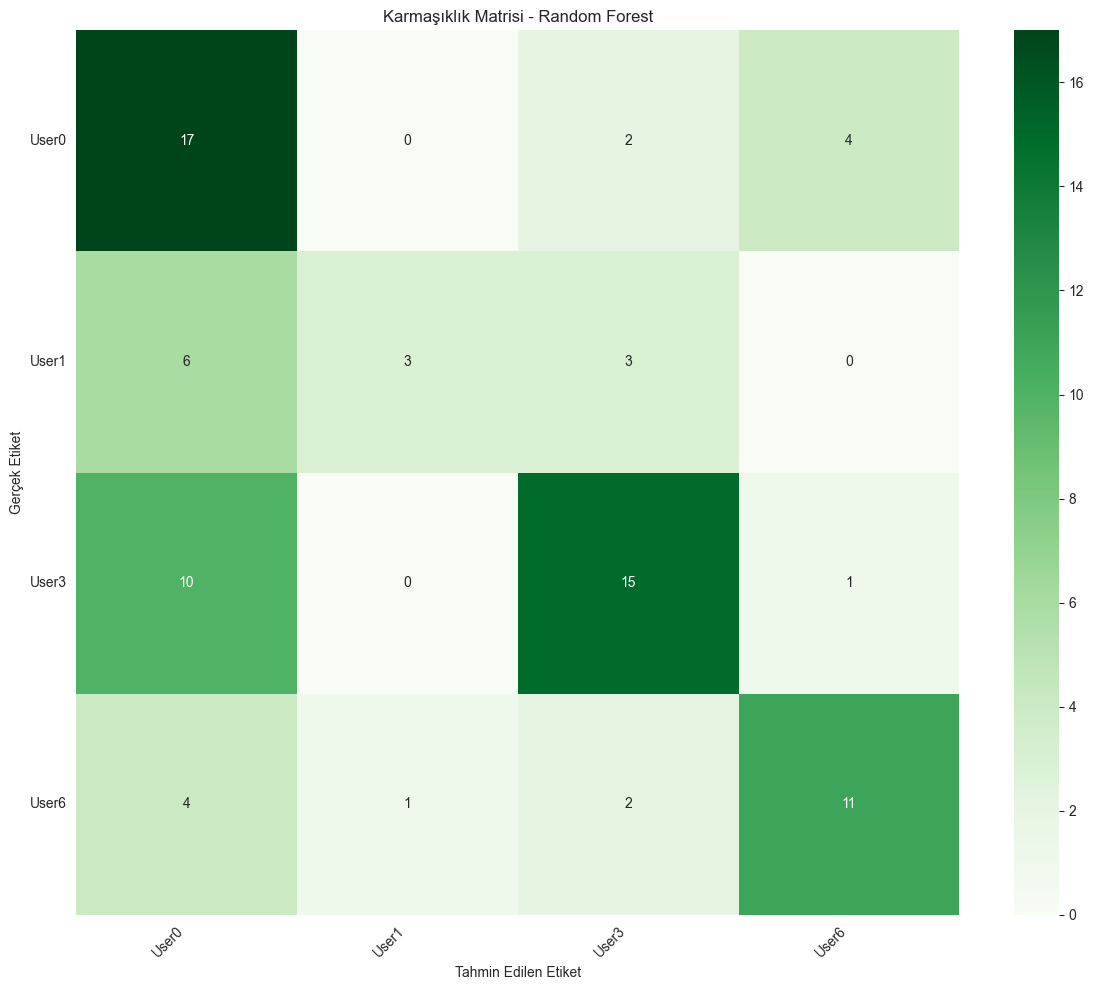

In [13]:
if 'X_train_scaled' in locals():
    print("--- Random Forest Modeli ---")

    # Random Forest modelini oluştur
    # random_state: tekrarlanabilirlik için
    # n_jobs=-1: tüm işlemcileri kullan
    # n_estimators: ormandaki ağaç sayısı (isteğe bağlı olarak ayarlanabilir)
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)

    # Modeli eğit
    print("Random Forest modeli eğitiliyor...")
    rf_model.fit(X_train_scaled, y_train)
    print("Model eğitimi tamamlandı.")

    # Test seti üzerinde tahmin yap
    y_pred_rf = rf_model.predict(X_test_scaled)

    # Performansı değerlendir
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    report_rf = classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_, zero_division=0)

    print(f"\nRandom Forest Doğruluk (Accuracy): {accuracy_rf:.4f}")
    print("\nRandom Forest Sınıflandırma Raporu:")
    print(report_rf)

    # Karmaşıklık Matrisi (Confusion Matrix)
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(12, 10)) # 20 sınıf için matris boyutunu ayarlayalım
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', # Renk paletini değiştirebilirsin (örn: 'Blues')
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Karmaşıklık Matrisi - Random Forest')
    plt.xlabel('Tahmin Edilen Etiket')
    plt.ylabel('Gerçek Etiket')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Eğitim verileri hazırlanmadığı için model eğitimi atlanıyor.")

## 5. Modelin, Ölçekleyicinin ve Etiket Kodlayıcının Kaydedilmesi

In [14]:
import joblib

if 'rf_model' in locals() and 'scaler' in locals() and 'label_encoder' in locals():
    try:
        # Modelin kaydedileceği dosya adı
        model_filename = 'randomforest_swipe_model.joblib' # Dosya adını güncelledik
        joblib.dump(rf_model, model_filename)
        print(f"Random Forest modeli '{model_filename}' olarak başarıyla kaydedildi.")

        # StandardScaler nesnesinin kaydedileceği dosya adı
        scaler_filename = 'scaler.joblib' # Bu aynı kalabilir
        joblib.dump(scaler, scaler_filename)
        print(f"StandardScaler nesnesi '{scaler_filename}' olarak başarıyla kaydedildi.")

        # LabelEncoder nesnesinin kaydedileceği dosya adı
        encoder_filename = 'label_encoder.joblib' # Bu da aynı kalabilir
        joblib.dump(label_encoder, encoder_filename)
        print(f"LabelEncoder nesnesi '{encoder_filename}' olarak başarıyla kaydedildi.")

        print("\nKaydedilen dosyalar Jupyter Notebook'un çalıştığı klasörde oluşturulacaktır.")
        print("Bu dosyaları BeagleBone Black'e aktarmanız gerekecek.")

    except Exception as e:
        print(f"Dosyalar kaydedilirken bir hata oluştu: {e}")
else:
    print("Model, scaler veya label_encoder eğitilmediği/oluşturulmadığı için kaydetme işlemi yapılamadı.")
    print("Lütfen önceki hücrelerin doğru çalıştığından emin olun.")

Random Forest modeli 'randomforest_swipe_model.joblib' olarak başarıyla kaydedildi.
StandardScaler nesnesi 'scaler.joblib' olarak başarıyla kaydedildi.
LabelEncoder nesnesi 'label_encoder.joblib' olarak başarıyla kaydedildi.

Kaydedilen dosyalar Jupyter Notebook'un çalıştığı klasörde oluşturulacaktır.
Bu dosyaları BeagleBone Black'e aktarmanız gerekecek.


In [15]:
# Yeni örneği uygun sütun isimleriyle DataFrame olarak oluştur
sample_data = {
    'rawT9': [86], 'rawT8': [80], 'rawT7': [74], 'rawT0': [13], 'rawT2': [62], 'rawT3': [64],
    'rawT6': [72], 'rawT5': [71], 'rawT4': [102], 'durationT9': [0], 'durationT8': [0],
    'durationT7': [0], 'durationT0': [53], 'durationT2': [0], 'durationT3': [0],
    'durationT6': [0], 'durationT5': [0], 'durationT4': [0]
}
sample_df = pd.DataFrame(sample_data)

# Ölçekleme
sample_scaled = scaler.transform(sample_df)

# Tahmin
pred_code = rf_model.predict(sample_scaled)[0]
pred_label = label_encoder.inverse_transform([pred_code])[0]
print(f"Tahmin edilen UserID kodu: {pred_code}, UserID etiketi: {pred_label}")

Tahmin edilen UserID kodu: 2, UserID etiketi: User3


In [16]:
# Yeni örnek veriyi uygun sütun isimleriyle oluştur
new_sample = {
    'rawT9': [83], 'rawT8': [15], 'rawT7': [76], 'rawT0': [62], 'rawT2': [60], 'rawT3': [65],
    'rawT6': [77], 'rawT5': [75], 'rawT4': [101], 'durationT9': [0], 'durationT8': [23],
    'durationT7': [0], 'durationT0': [0], 'durationT2': [0], 'durationT3': [0],
    'durationT6': [0], 'durationT5': [0], 'durationT4': [0]
}
new_sample_df = pd.DataFrame(new_sample)

# Ölçekleme
new_sample_scaled = scaler.transform(new_sample_df)

# Tahmin
new_pred_code = rf_model.predict(new_sample_scaled)[0]
new_pred_label = label_encoder.inverse_transform([new_pred_code])[0]
print(f"Tahmin edilen UserID kodu: {new_pred_code}, UserID etiketi: {new_pred_label}")

Tahmin edilen UserID kodu: 3, UserID etiketi: User6
